In [ ]:
!pip install lightning==2.0.0

In [1]:
!pip install fastbook
from fastbook import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 18.8 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import os

In [3]:
from datasets import load_dataset

train_ds = load_dataset('ceyda/fashion-products-small') #smaller version of the original data set

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/ceyda--fashion-products-small-ad468eb94e8d93de/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
train_ds = train_ds['train'].train_test_split(test_size=0.15)

In [5]:
train_data = train_ds['train']
test_data = train_ds['test']

In [6]:
train_data

Dataset({
    features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image'],
    num_rows: 36295
})

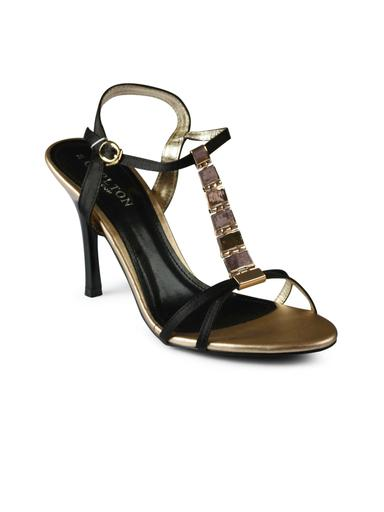

In [7]:
train_data[1234]['image']

In [8]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm 
import requests

destination_folder = 'dataset' 

# Perform the copy operation for each masterCategory
master_categories = set(train_data['masterCategory'])
for category in master_categories:
    category_folder = os.path.join(destination_folder, category)
    os.makedirs(category_folder, exist_ok=True)

for i in tqdm(range(300)): # 300 samples
    master_category = train_data['masterCategory'][i]
    filename = train_data['filename'][i]
    link = train_data['link'][i]

    category_folder = os.path.join(destination_folder, master_category)
    os.makedirs(category_folder, exist_ok=True)

    destination_path = os.path.join(category_folder, filename)

    # Download and copy data directly from the internet
    response = requests.get(link, stream=True)
    with open(destination_path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response

100%|██████████| 300/300 [16:30<00:00,  3.30s/it]


In [9]:
path = Path('/kaggle/working/dataset')

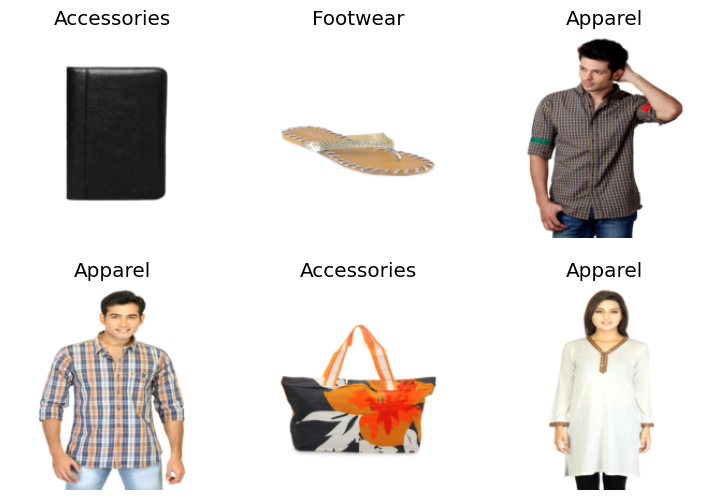

In [10]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=0),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)
dls.show_batch(max_n=6)

In [11]:
learn = cnn_learner(dls, resnet152, metrics=accuracy, lr=0.0001)
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 66.8MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,2.443159,0.614379,0.750000,03:04


epoch,train_loss,valid_loss,accuracy,time
0,0.663634,0.493504,0.866667,03:59
1,0.497234,0.336794,0.916667,02:49
2,0.380662,0.226564,0.933333,02:21
3,0.295104,0.183387,0.933333,03:36
4,0.243353,0.129288,0.933333,03:49


In [12]:
interp = ClassificationInterpretation.from_learner(learn) #https://atmamani.github.io/projects/dl/fastai/lesson1-pets/

losses,idxs = interp.top_losses()

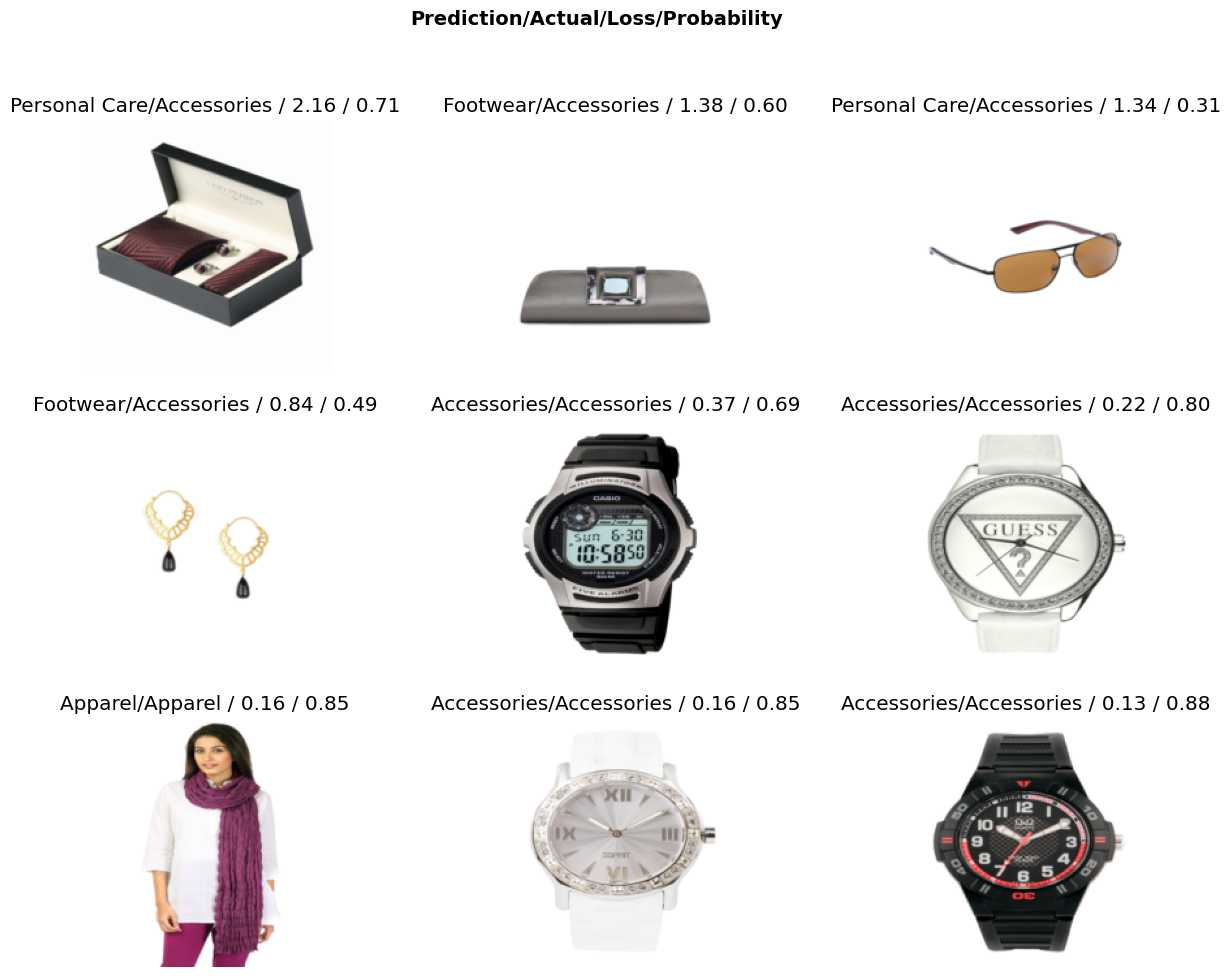

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

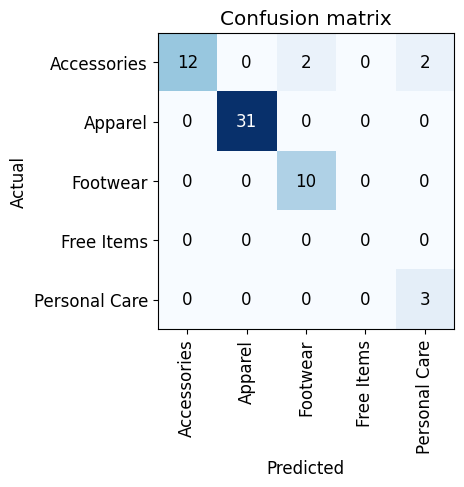

In [14]:
def plot_confusion_matrix(learner):  ## https://www.kaggle.com/code/nitzanshulman/fastai-99-cnn
    """
    Ploting a confusion matrix using a fastai cnn learner
    """
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()
    
plot_confusion_matrix(learn)